In [1]:
## load required libraries 
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from pdpbox import pdp, get_dataset, info_plots
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
from collections import Counter
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import warnings
import eli5
warnings.filterwarnings('ignore')

In [2]:
# Importing data
df_ks = pd.read_csv("../Data/Cleaned/latest_data.csv")

In [3]:
df_ks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242630 entries, 0 to 242629
Columns: 244 entries, backers_count to ['category']_Zines
dtypes: bool(2), float64(6), int64(231), object(5)
memory usage: 448.4+ MB


## Remove Uninteresting or Text-based Features

In [4]:
# Drop text-based columns
df_ks = df_ks.drop(columns=['blurb', 'name'])
# Drop uninteresting columns
df_ks = df_ks.drop(columns=['launch_hour','backers_count','staff_pick', 'spotlight', 'usd_pledged_real'])

#### Also removing redundant features (launched, deadline, etc.) 

In [5]:
df_ks = df_ks.drop(columns=['deadline','launched'])

In [6]:
df_ks.columns

Index(['blurb_length', 'state', 'usd_goal_real', 'hours_since_last_project',
       'launch_day', 'launch_month', 'launch_year', 'deadline_day',
       'deadline_month', 'deadline_year',
       ...
       '['category']_Wearables', '['category']_Weaving', '['category']_Web',
       '['category']_Webcomics', '['category']_Webseries',
       '['category']_Woodworking', '['category']_Workshops',
       '['category']_World Music', '['category']_Young Adult',
       '['category']_Zines'],
      dtype='object', length=235)

## Baseline Decision Tree

In [ ]:
# Trying out Model off the shelf
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

# Initial model selection process
models = []
models.append(('DT', DecisionTreeClassifier()))

In [ ]:
# Dropping Generated Features
feature_names = df_ks.drop(columns=['state','duration_days','hours_since_last_project','count_7_days','optimism']).columns
X = df_ks[feature_names]
y = df_ks.state

In [ ]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df_ks.state, random_state=42)

## Random Forest to Choose Top N Features

In [9]:
from sklearn.model_selection import train_test_split

## define predictors and label 
label = df_ks.state
features = [c for c in df_ks.columns if c not in ["state"]]

## prepare training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(df_ks[features], label, test_size = 0.025, random_state =42)
X_train1, y_train1 = X_train, y_train
X_test1, y_test1 = X_test, y_test

## train a random forest classifier 
model1 = RandomForestClassifier(n_estimators=50, random_state=0).fit(X_train1, y_train1)
y_pred = model1.predict(X_test1)

In [16]:
feature_importances = pd.DataFrame(model1.feature_importances_, index = X_train.columns, columns=['importance'])
feature_importances = feature_importances.sort_values('importance', ascending=False)

colors = ["gray"] * 9 + ["green"]*6
trace1 = go.Bar(y = [x.title()+"  " for x in feature_importances.index[:15][::-1]], 
                x = feature_importances.importance[:15][::-1], 
                name="feature importance (relative)",
                marker=dict(color=colors, opacity=0.4), orientation = "h")

data = [trace1]

layout = go.Layout(
    margin=dict(l=400), width = 1000,
    xaxis=dict(range=(0.0,0.15)),
    title='Relative Feature Importance (Which Features are important to make predictions ?)',
    barmode='group',
    bargap=0.25
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

from IPython.display import display
from IPython.core.display import HTML

tag = "<div> Most Important (Relative) : "
for feat in feature_importances.index[:20]:
    tag += "<span><font color='green'>" +feat.title().replace("_","")+ "</font> &nbsp;|&nbsp; </span>" 
tag += "<br>Least Important (Relative) : "
for feat in feature_importances.index[-15:]:
    tag += "<span><font color='red'>" +feat.title().replace("_","")+ "</font> &nbsp;|&nbsp; </span>" 
tag += "</div>"
display(HTML(tag))

### Notes:
* Looks like the Category has some impact
* Others like main category (which is redundant), as well as location_state may be less relevant.

### Looks like the location of smaller cities don't matter. Maybe we should remove these features. 

## Backward Elimination
Too many features -- need to maybe get rid of a few?

In [ ]:
# step forward feature selection

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# step backward feature elimination
sfs1 = SFS(RandomForestRegressor(), 
           k_features=10, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=3)

sfs1 = sfs1.fit(np.array(X_train), y_train)

## Permutation Importance -- Takes too long
* Only on the relevant features

In [ ]:
from eli5.sklearn import PermutationImportance
import eli5

features = [c for c in df_ks.columns if c in ["Count7Days","UsdGoalReal","optimism"]]

perm = PermutationImportance(model1, random_state=1).fit(X_test, y_test)
pi_df = eli5.explain_weights_df(perm, feature_names = features)
pi_df["color"] = pi_df["weight"].apply(lambda x : "green" if x > 0 else "red")

data = [
    go.Bar(
        orientation = "h",
        y = pi_df.feature[::-1],
        x = pi_df.weight[::-1],
        marker = dict(
            opacity = 0.5,
            color = pi_df.color[::-1]        ),
        error_x = dict( type='data', color="#9fa3a3",
            array=list(pi_df["std"][::-1]),
            visible=True),
        name = 'expenses'
    )
]


layout = go.Layout(title="Permutation Importance", height = 800, margin=dict(l=300))

annotations = []
for i, row in pi_df.iterrows():
    dict(y=row.feature, x=row.weight, text="d",
                                  font=dict(family='Arial', size=14,
                                  color='rgba(245, 246, 249, 1)'),
                                  showarrow=False,)
layout['annotations'] = annotations
fig = go.Figure(data=data, layout = layout)
iplot(fig, filename='base-bar')

## Partial Dependencies 

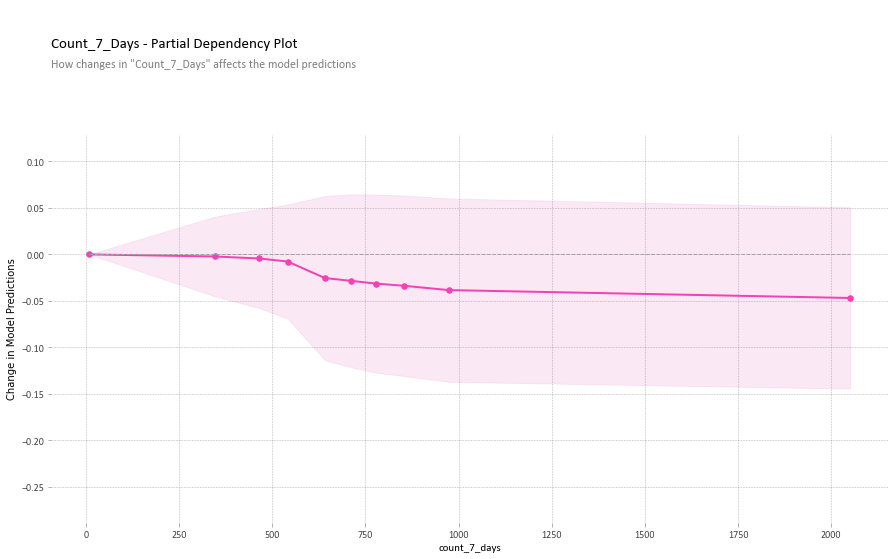

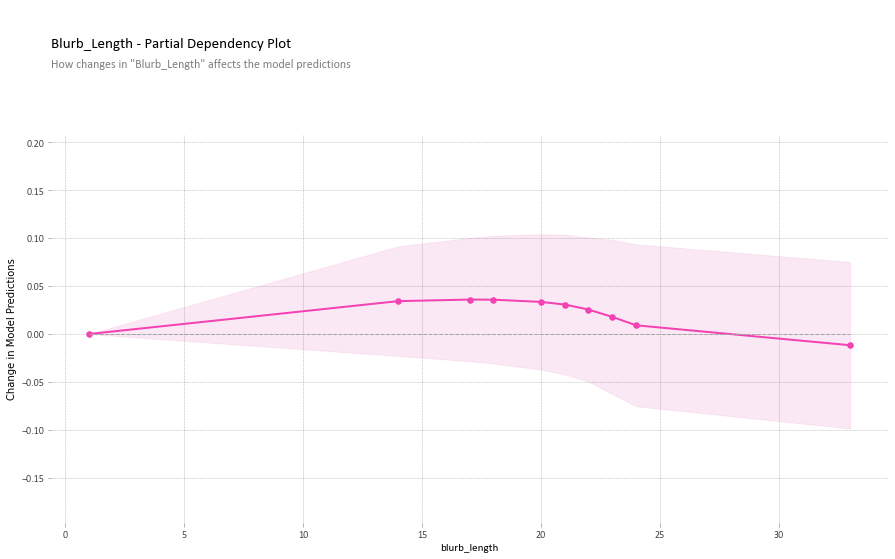

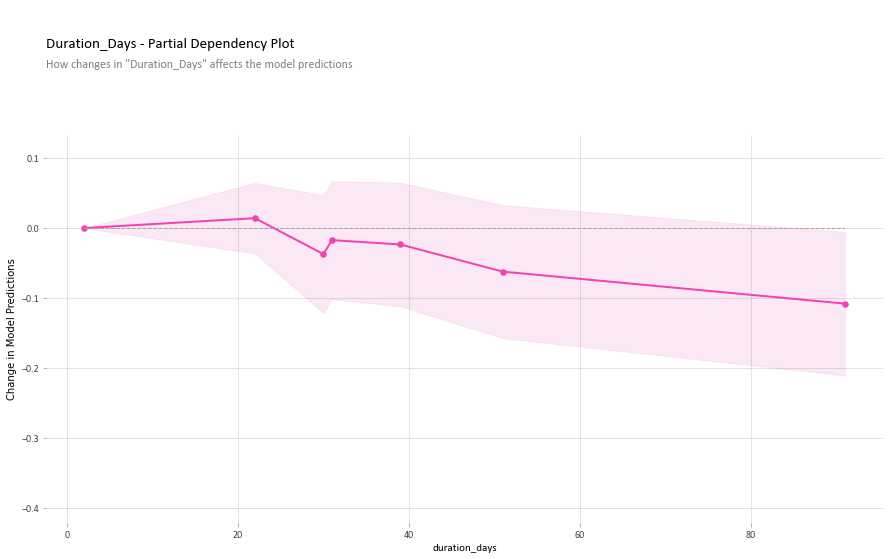

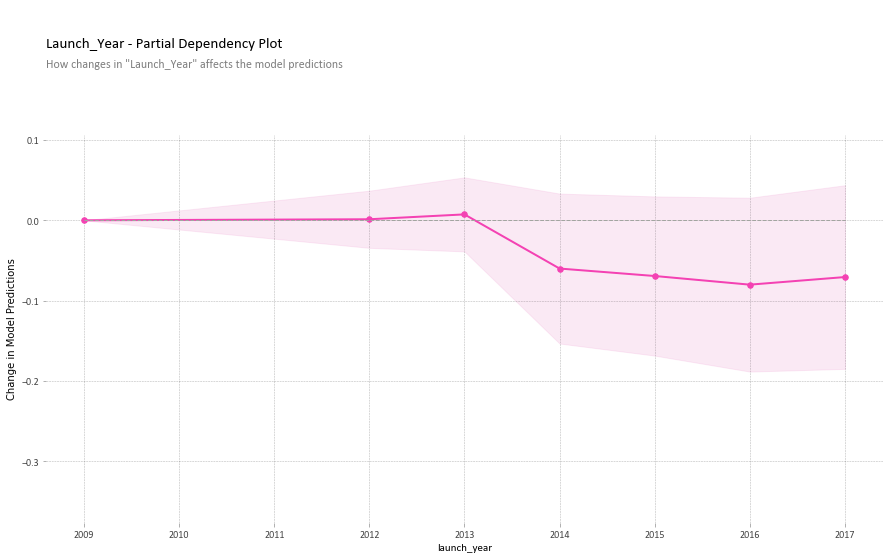

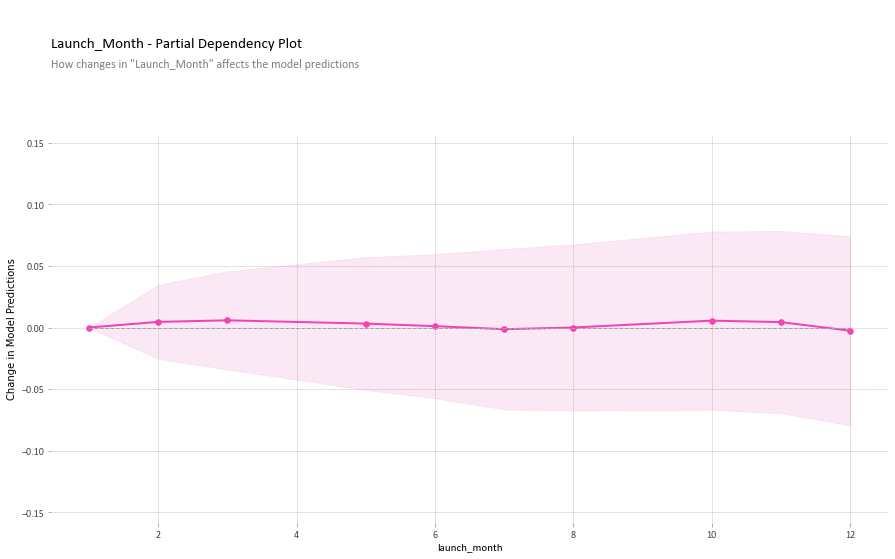

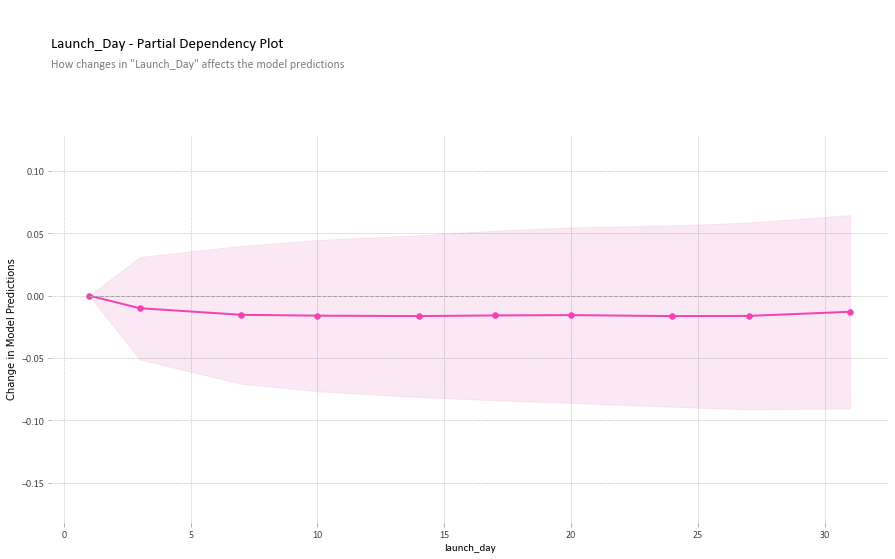

In [11]:
def _plot_pdp(feature, pdp_color, fill_color):
    plot_params = {
        'title': feature.title() + ' - Partial Dependency Plot',
        'title_fontsize': 15,
        'subtitle': 'How changes in "%s" affects the model predictions' % feature.title(),
        'subtitle_fontsize': 12,
        'font_family': 'Calibri',
        'xticks_rotation': 0,
        'line_cmap': 'cool',
        'zero_color': '#a2a5a0',
        'zero_linewidth': 1.0,
        'pdp_linewidth': 2.0,
        'fill_alpha': 0.25,
        'markersize': 5.5,
        'pdp_hl_color': 'green',
        'pdp_color': pdp_color,
        'fill_color': fill_color,

    }
    pdp_goals = pdp.pdp_isolate(model=model1, dataset=X_test1, model_features=X_test1.columns, feature=feature)
    pdp.pdp_plot(pdp_goals, feature, plot_params = plot_params)
    plt.ylabel("Change in Model Predictions");
    plt.show();
    
cols_of_interest = ['count_7_days','blurb_length','duration_days', 'launch_year','launch_month', 'launch_day', 'optimism']

_plot_pdp(cols_of_interest[0], "#f442b3", "#efaad6")
_plot_pdp(cols_of_interest[1], "#f442b3", "#efaad6")
_plot_pdp(cols_of_interest[2], "#f442b3", "#efaad6")
_plot_pdp(cols_of_interest[3], "#f442b3", "#efaad6")
_plot_pdp(cols_of_interest[4], "#f442b3", "#efaad6")
_plot_pdp(cols_of_interest[5], "#f442b3", "#efaad6")

## Discretize the values of top relevant features:     Split into low, medium, then high